# Part 3

### Question 3: Parameter-Sharing Scheme for 2D Linear Equivariant Layer

In [ ]:
import torch
import matplotlib.pyplot as plt

M = 8
N = 7

W = torch.zeros(M, N, M, N)
A = torch.randn(M, N)

for i1 in range(M):
    for j1 in range(N):
        for i2 in range(M):
            for j2 in range(N):
                if i1 == i2 and j1 == j2:
                    W[i1, j1, i2, j2] = 1
                elif i1 == i2 and j1 != j2:
                    W[i1, j1, i2, j2] = 2
                elif i1 != i2 and j1 == j2:
                    W[i1, j1, i2, j2] = 3
                else:
                    W[i1, j1, i2, j2] = 4

plt.imshow(W.reshape(M * N, M * N).to(torch.int32), cmap="tab10")

### Question 5: Parameter-Sharing Scheme for 3D Linear Equivariant Layer

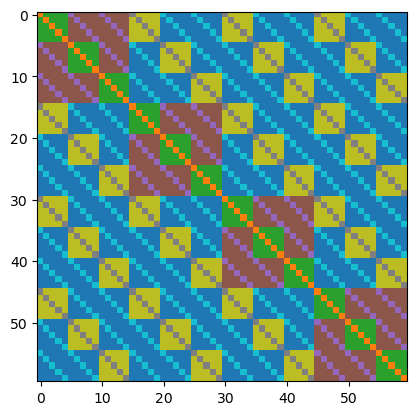

In [1]:
import torch
import matplotlib.pyplot as plt

M = 4
N = 3
K = 5

W = torch.zeros(M, N, K, M, N, K)
A = torch.randn(M, N, K)

for i1 in range(M):
    for j1 in range(N):
        for p1 in range(K):
            for i2 in range(M):
                for j2 in range(N):
                    for p2 in range(K):
                        if i1 == i2 and j1 == j2 and p1 == p2:
                            W[i1, j1, p1, i2, j2, p2] = 1
                        if i1 == i2 and j1 == j2 and p1 != p2:
                            W[i1, j1, p1, i2, j2, p2] = 2
                        if i1 == i2 and j1 != j2 and p1 == p2:
                            W[i1, j1, p1, i2, j2, p2] = 3
                        if i1 == i2 and j1 != j2 and p1 != p2:
                            W[i1, j1, p1, i2, j2, p2] = 4
                        if i1 != i2 and j1 == j2 and p1 == p2:
                            W[i1, j1, p1, i2, j2, p2] = 5
                        if i1 != i2 and j1 == j2 and p1 != p2:
                            W[i1, j1, p1, i2, j2, p2] = 6
                        if i1 != i2 and j1 != j2 and p1 == p2:
                            W[i1, j1, p1, i2, j2, p2] = 7
                        if i1 != i2 and j1 != j2 and p1 != p2:
                            W[i1, j1, p1, i2, j2, p2] = 0

plt.imshow(W.reshape(M * N * K, M * N * K).to(torch.int32), cmap="tab10")

# Part 5

The following models were analyzed throughout this experiment:

* *canonical-mlp* - MLP architecture with canonized-inputs        
* *canonical-attn* - Transformer encoder with canonized-inputs       
* *symmetry-mlp* - MLP architecture applied to all input permutations         
* *symmetry-attn* - Transformer encoder applied to all input permutations        
* *symmetry-sampling-mlp* - MLP architecture applied to 10 random input permutations
* *symmetry-sampling-attn* - Transformer encoder applied to 10 random input permutations 
* *intrinsic* - Intrinsic invariant architecture made from equivariant and invariant linear layers            
* *augmented-mlp* - MLP architecture with random permutation applied to the inputs during training       
* *augmented-attn* - Transformer encoder with random permutation applied to the inputs during training       

It's important to note that the symmetry model (without sub-sampling) are not present in the plots since the number of different permutations for $N=10$ is $N!=3628800$, and the model is not able to perform even a single forward pass for this number of permutations. Even when sub-sampling 5% of the permutations, the number of permutations is still too high for the model to handle. As result, in the symmetry-sampling models we sampled 10 random permutations instead.

### Question 1: Plots

##### Train-Set 100 ; N = 10

![text](images/train100_seq10_train.png)

![text](images/train100_seq10_test.png)

##### Train-Set 100 ; N = 100

![text](images/train100_seq100_train.png)

![text](images/train100_seq100_train.png)

##### Train-Set 1000 ; N = 10

![text](images/train1000_seq10_train.png)

![text](images/train1000_seq10_test.png)

##### Train-Set 1000 ; N = 100

![text](images/train1000_seq100_train.png)

![text](images/train1000_seq100_train.png)

##### Train-Set 10000 ; N = 10

![text](images/train10000_seq10_train.png)

![text](images/train10000_seq10_test.png)

##### Train-Set 10000 ; N = 100

![text](images/train10000_seq100_train.png)

![text](images/train10000_seq100_train.png)

### Question 2: Tables

##### Invariance:

|          Model         | Invariant |
|------------------------|:---------:|
| canonical-mlp          | T         |
| canonical-attn        | T         |
| symmetry-mlp           | T         |
| symmetry-attn          | T         |
| symmetry-sampling-mlp  | F         |
| symmetry-sampling-attn | F         |
| intrinsic              | T         |
| augmented-mlp          | F         |
| augmented-attn         | F         |


##### Performance Metrics:   

The performance were measured on input batch of size (32, N, 5) and on a CPU.

| Model                  | N = 10         | N = 10        | N = 100        | N = 100       |
| ---------------------- | -------------- | ------------- | -------------- | ------------- |
|                        | Inference (ms) | Training (ms) | Inference (ms) | Training (ms) |
| canonical-mlp          | 0.12           | 0.36          | 0.28           | 0.54          |
| canonical-attn        | 0.86           | 4.47          | 10.77          | 46.38         |
| symmetry-mlp           | OOT            | OOT           | OOT            | OOT           |
| symmetry-attn          | OOT            | OOT           | OOT            | OOT           |
| symmetry-sampling-mlp  | 0.6            | 0.95          | 0.99           | 1.56          |
| symmetry-sampling-attn | 11.21          | 46.38         | 110.78         | 482.51        |
| intrinsic              | 0.27           | 0.94          | 1.01           | 2.36          |
| augmented-mlp          | 0.08           | 0.44          | 0.12           | 0.54          |
| augmented-attn         | 0.85           | 4.68          | 11.46          | 48.58         |

### Question 4: Challenges encountered during Implementation:

##### Numeric Errors:

Originally, we constructed the invariant network as follows:

```python

def create_invariant_model(n: int, d: int) -> nn.Module:
    return nn.Sequential(
        LinearEquivariant(in_channels=d, out_channels=10),
        nn.ReLU(),
        LinearEquivariant(in_channels=10, out_channels=10),
        nn.ReLU(),
        LinearInvariant(in_channels=10, out_channels=1),
        nn.Sigmoid(),
    )

```

The problem that arises from this architecture is that the output range of the LinearInvariant is quite large, very often producing large numbers (i.e. 1000).
As result, the sigmoid activation function would saturate, and return binary results (0 or 1) for all inputs. Since the gradient of Sigmoid is zero for outputs 0 or 1, the model would not learn. 

To mitigate this issue I employed two techniques:
* First, in the Custom layers we implemented proper weight and initialization $W \sim \mathcal{U}\left(-\frac{1}{\sqrt{c_{out}}}, \frac{1}{\sqrt{c_{out}}}\right)$ which is a common practice in deep learning. That partially solved the problem, but not entirely.

* Second, I added a `nn.BatchNorm1d(num_features=1)` layer after the `LinearInvariant` layer, right before the sigmoid function. It learns the mean and variance of the outputS of the `LinearInvariant` layer during the training process, and normalizes it to variance 1 and expectancy 0 (on average). It's important to note that the batch normalization layer keeps the model invariant, since it simply multiplies scalar outputs by a learned scalar factor and adds a learned scalar bias. Indeed, using the batch normalization layer solved the problem of the model not learning. Since the batch normalization layer normalizes the inputs to the sigmoid function, it no longer saturates and the model can learn.
Although it might take a while for the `BatchNorm1d` layer to learn the proper normalization coefficients, once it does the model trains very quickly. 

Resulting Architecture:

```python
 def create_invariant_model(n: int, d: int) -> nn.Module:
    return nn.Sequential(
        LinearEquivariant(in_channels=d, out_channels=10),
        nn.ReLU(),
        LinearEquivariant(in_channels=10, out_channels=10),
        nn.ReLU(),
        LinearInvariant(in_channels=10, out_channels=1),
        nn.BatchNorm1d(1),
        nn.Sigmoid(),
    )
```

##### Overfitting:

Another big issue we encountered was overfitting. To overcome it, we added an option to dynamically generate the data every time the `Dataset` is accessed. 
This way, the model never sees the same data twice, and not able to overfit. That indeed resolved completely the overfitting issue.

##### Symmetrization Network:

The symmetrization network is a very powerful tool to learn equivariant functions. However, it is computationally expensive
and tricky to implement efficiently. Our implementation balances performance and memory utilization by forwarding through the network multiple 
permuted versions of the input data at once (by creating a super-batch). We can control that number of forwarded permutations to balance performance and memory (more permutations - better performance but higher memory utilization).

### Question 6 and 7:

The reason that the equivariant architecture is especially suited for this task is the following:

Given $d$ dimensional random vector $x = (x_1, x_2, ..., x_d) \sim \mathcal{D^d}$, the formula for the empirical variance is as follows:

$$ {Var}_{em}(x) = \frac{1}{d - 1} \sum_{i=1}^{d} (x_i - \bar{x})^2 $$

$$ \bar{x} = \frac{1}{d} \sum_{i=1}^{d} x_i $$

Notice that this calculation can be easily achieved by the the following invariant architecture:

($I_{d \times d}$ denotes the identity matrix, $1_{d \times d}$ denotes the matrix filled with ones, and $0_{d}$ denotes the zero vector)

Let $N = \phi \circ \alpha \circ F$ be an invariant network, where $\phi$ is invariant layer, $\alpha$ is pointwise activation, and $F$ is an equivariant layer.

* Define $F : \mathbb{R}^d \rightarrow \mathbb{R}^d$ as follows: $ F = 1 \cdot I_{d \times d} + \frac{-1}{d} \cdot {1}_{d \times d} + 0_{d}$
(recall that general equivariant $F$ is of the form $ F = \alpha \cdot I_{d \times d} + \beta \cdot {1}_{d \times d} + b$)

* Define $\alpha : \mathbb{R} \rightarrow \mathbb{R}$ as follows: $ \alpha(x) = x^2 $

* Define $\phi : \mathbb{R}^d \rightarrow \mathbb{R}$ as follows: $ \phi = \frac{1}{d-1} \cdot 1_{d} + 0$ (recall that general invariant $\phi$ is of the form $ \phi = \alpha \cdot 1_{d} + b$)

As result, we get:

$$ F(x)_i = x_i - \frac{1}{d} \sum_{j=1}^{d} x_j + 0 = x_i - \bar{x} $$

$$ \alpha(F(x))_i = F(x)_i^2 = (x_i - \bar{x})^2 $$

$$ N(x) = \frac{1}{d-1} \sum_{i=1}^{d} \alpha(F(x))_i = \frac{1}{d-1} \sum_{i=1}^{d} (x_i - \bar{x})^2 = \text{Var}_{em}(x) $$

We showed that using the invariant and equivariant layers only, we were able to calculate the empirical variance of an input sample. 
Since the task of the model is to differentiate between inputs generated from distributions with different variances, the equivariant architecture is especially suited for this task.
Notice the small number of parameters required to calculate the variance (3 parameters in layer $F$ and two parameters in layer $\phi$), hence the optimization process of this architecture is easier than for other architectures.

*Note: We showed how to calculate the variance across a single feature dimension, but the same idea holds for calculating the variance for each feature for element of size $(n \times d)$, and afterwards averaging the empirical variances across the feature dimension to get the final variance of the sample.*

### Question 8:

Currently, we're using the symmetry group $S_n$ over the channel dimensions.
A better symmetry group to use would be $S_n \times S_d$ when $S_n$ acts on the channel dimension and $S_d$ acts on the feature dimension. The reason this symmetry group is suitable is because each feature is a vector of length $d$ generated from a normal distribution, and any permutation of the vector does not change the probability of it being generated, nor the underlying distribution that generated it. Since the model tries to detect the underlying distribution, it should be invariant to permutations of the feature dimensions.

Formally:

$$ \Pr(x_1, x_2, ... x_n \sim \mathcal{N}(0, I) \; | \; x_1, x_2, ... x_n) = 
\Pr(\sigma \cdot x_1, \sigma \cdot x_2, ... \sigma \cdot x_n \sim \mathcal{N}(0, I) \; | \; x_1, x_2, ... ,x_n, \forall \sigma \in S_d) $$

when $x_i$ is a feature vector of length $d$ and $\sigma$ is a permutation of the feature dimensions
(remember that each input sample is composed of $n$ feature vectors of length $d$).